# Converting Microscopy Images with a CycleGAN

This notebook provides you with a complete code example to convert between holographic and brightfield images using a CycleGAN.

## Downloading and Preparing the Holo2Bright Dataset

The Holo2Bright dataset consists of holographic and brightfield microscopy images of marine microplankton. The dataset consists of 4500 holographic images and 880 brightfield images for training, and 4500 holographic images and 244 brightfield images for testing. The size of all images is 256 by 256 pixels.

Download the Holo2Bright dataset ...

In [1]:
import os

if not os.path.exists("holo2bright_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/holo2bright_dataset")

... implement a Dataset object to manage the images ...

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image

class Holo2BrightDataset(Dataset):
    """Dataset conatining the Holo2Bright dataset."""

    def __init__(self, directory, transform=None):
        """Initialize dataset."""
        self.transform = transform

        self.holography_dir = os.path.join(directory, "holography")
        self.holography_images = os.listdir(self.holography_dir)

        self.brightfield_dir = os.path.join(directory, "brightfield")
        self.brightfield_images = os.listdir(self.brightfield_dir)

    def __len__(self):
        """Return number of holographic-brightfield image couples."""
        return min(len(self.brightfield_images), len(self.holography_images))

    def __getitem__(self, index):
        """Get next holographic-brightfield image couple."""
        holography_image = Image.open(
            os.path.join(self.holography_dir, self.holography_images[index])
        )
        brightfield_image = Image.open(
            os.path.join(self.brightfield_dir, self.brightfield_images[index])
        )

        if self.transform:
            seed = np.random.randint(1_000_000_000)

            torch.manual_seed(seed)
            holography_image = self.transform[0](holography_image)

            torch.manual_seed(seed)
            brightfield_image = self.transform[1](brightfield_image)

        return holography_image, brightfield_image

... implement the necessary augmentations, transformations, and normalizations ...

In [3]:
from torchvision import transforms

trans_holo = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
trans_bright = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

... create the training and testing datasets ...

In [4]:
train_dataset = Holo2BrightDataset(
    directory=os.path.join("holo2bright_dataset", "holo2bright", "train"),
    transform=[trans_holo, trans_bright],
)
test_dataset = Holo2BrightDataset(
    directory=os.path.join("holo2bright_dataset", "holo2bright", "train"),
    transform=[trans_holo, trans_bright],
)

... and plot some holographic and brightfield images.

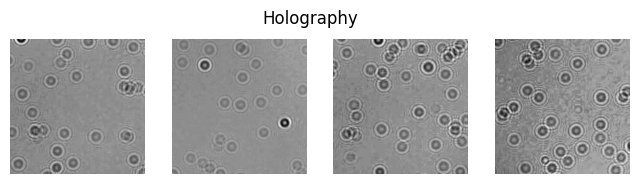

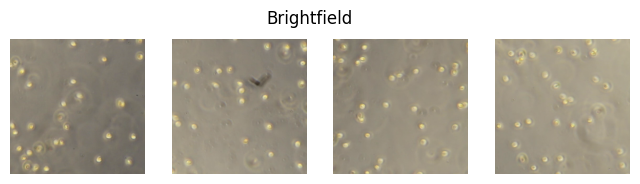

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    ax[i].imshow(train_dataset[i][0][0], cmap="gray")
    ax[i].axis("off")
fig.suptitle("Holography")
plt.show()

fig, ax = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    img = train_dataset[i][1].permute(1, 2, 0).numpy()
    img = (((img * 0.5) + 0.5) * 255.0).astype(np.uint8)
    ax[i].imshow(img)
    ax[i].axis("off")
fig.suptitle("Brightfield")
plt.show()

## Instantiating the CycleGAN Generators and Discriminators

Determine the device to be used in the computations ...

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

... define the generators ...

In [7]:
import deeplay as dl

generator_H2B = dl.CycleGANResnetGenerator(in_channels=1, out_channels=3) \
    .build()
generator_H2B.to(device)

print(generator_H2B)

CycleGANResnetGenerator(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (reflectionpad2d): ReflectionPad2d((3, 3, 3, 3))
        (layer): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
        (normalization): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (normalization): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (normalization): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (activation): ReLU()
      )
    )
    (postprocess): Identity()
  )
  (bottleneck): ConvolutionalNeuralNetwork(
    (blocks): LayerLis

In [8]:
generator_B2H = dl.CycleGANResnetGenerator(in_channels=3, out_channels=1) \
    .build()
generator_B2H.to(device);

print(generator_B2H)

CycleGANResnetGenerator(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (reflectionpad2d): ReflectionPad2d((3, 3, 3, 3))
        (layer): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
        (normalization): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (normalization): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (normalization): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (activation): ReLU()
      )
    )
    (postprocess): Identity()
  )
  (bottleneck): ConvolutionalNeuralNetwork(
    (blocks): LayerLis

... define the discriminators ...

In [9]:
discriminator_H = dl.CycleGANDiscriminator(in_channels=1).build()
discriminator_H.to(device)

print(discriminator_H)

CycleGANDiscriminator(
  (blocks): LayerList(
    (0): Conv2dBlock(
      (layer): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (1): Conv2dBlock(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (layer): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (2): Conv2dBlock(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (layer): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (3): Conv2dBlock(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=

In [10]:
discriminator_B = dl.CycleGANDiscriminator(in_channels=3).build()
discriminator_B.to(device);

print(discriminator_B)

CycleGANDiscriminator(
  (blocks): LayerList(
    (0): Conv2dBlock(
      (layer): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (1): Conv2dBlock(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (layer): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (2): Conv2dBlock(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (layer): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (3): Conv2dBlock(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=

... define the losses ...

In [11]:
loss_G = torch.nn.L1Loss()
loss_D = torch.nn.MSELoss()

In [12]:
optimizer_G = torch.optim.Adam(
    list(generator_H2B.parameters()) + list(generator_B2H.parameters()),
    lr=0.0002,
    betas=(0.5, 0.999),
)
optimizer_D = torch.optim.Adam(
    list(discriminator_H.parameters()) + list(discriminator_B.parameters()),
    lr=0.0002,
    betas=(0.5, 0.999),
)

... and define the data loaders.

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                          shuffle=True)

## Training the CycleGAN

Implement a function to train the CycleGAN ...

In [14]:
def train_model(input_image_H, input_image_B, optimizer_disc, optimizer_gen, 
                L1_Lambda_H, L1_Lambda_B):
    """Train CycleGAN for one epoch."""
    # 1. Training discriminators.
    optimizer_disc.zero_grad()

    # Train discriminator B (as a part of the transformation H -> B).
    fake_image_B = generator_H2B(input_image_H)
    disc_B_fake = discriminator_B(fake_image_B.detach())
    disc_B_real = discriminator_B(input_image_B)

    # Compute discriminator B losses.
    disc_B_loss_real = loss_D(disc_B_real, torch.ones_like(disc_B_real))
    disc_B_loss_fake = loss_D(disc_B_fake, torch.zeros_like(disc_B_fake))
    disc_B_loss = disc_B_loss_real + disc_B_loss_fake

    # Train discriminator H (as a part of the transformation B -> H).
    fake_image_H = generator_B2H(input_image_B)
    disc_H_real = discriminator_H(input_image_H)
    disc_H_fake = discriminator_H(fake_image_H.detach())

    # Compute discriminator H losses.
    disc_H_loss_real = loss_D(disc_H_real, torch.ones_like(disc_H_real))
    disc_H_loss_fake = loss_D(disc_H_fake, torch.zeros_like(disc_H_fake))
    disc_H_loss = disc_H_loss_real + disc_H_loss_fake

    # Total discriminator loss, backpropagation, and weight update.
    disc_loss = (disc_B_loss + disc_H_loss) / 2
    disc_loss.backward()
    optimizer_disc.step()

    # 2. Training generators.
    optimizer_gen.zero_grad()
    
    # Train generators.
    disc_B_fake = discriminator_B(fake_image_B)
    disc_H_fake = discriminator_H(fake_image_H)

    # Adversarial loss (from generators perspective).
    gen_H2B_loss = loss_D(disc_B_fake, torch.ones_like(disc_B_fake))
    gen_B2H_loss = loss_D(disc_H_fake, torch.ones_like(disc_H_fake))

    # 3. Cycle consistency loss
    cycle_H = generator_B2H(fake_image_B)
    cycle_B = generator_H2B(fake_image_H)
    cycle_H_loss = loss_G(input_image_H, cycle_H)
    cycle_B_loss = loss_G(input_image_B, cycle_B)

    # Total generator loss, backpropagation, and weight update.
    gen_loss = (
        gen_H2B_loss
        + gen_B2H_loss
        + L1_Lambda_H * cycle_H_loss
        + L1_Lambda_B * cycle_B_loss
    )
    gen_loss.backward()
    optimizer_gen.step()

    return disc_loss, gen_loss

... implement a function to evaluate the CycleGAN ...

In [15]:
def evaluate_model(image_H, image_B):
    """Evaluate CycleGAN in each epoch."""
    # Generate fake images 
    generator_H2B.eval(), generator_B2H.eval()
    fake_image_B, fake_image_H = generator_H2B(image_H), generator_B2H(image_B)
    generator_H2B.train(), generator_B2H.train()
    
    fig, ax = plt.subplots(2, 2, figsize=(5,5))

    img_H_in = image_H[0].permute(1, 2, 0).cpu().detach().numpy()
    ax[0, 0].imshow(img_H_in, cmap="gray")
    ax[0, 0].set_title("Input: Holographic image", fontsize=8)
    ax[0, 0].axis("off")

    img_B_in = image_B[0].permute(1, 2, 0).cpu().detach().numpy()
    img_B_in = (((img_B_in * 0.5) + 0.5) * 255.0).astype(np.uint8)
    ax[1, 0].imshow(img_B_in)
    ax[1, 0].set_title("Input: Brightfield image", fontsize=8)
    ax[1, 0].axis("off")

    img_B_out = fake_image_B[0].permute(1, 2, 0).cpu().detach().numpy()
    img_B_out = (((img_B_out * 0.5) + 0.5) * 255.0).astype(np.uint8)
    ax[0, 1].imshow(img_B_out)
    ax[0, 1].set_title("Output: Brightfield image", fontsize=8)
    ax[0, 1].axis("off")

    img_H_out = fake_image_H[0].permute(1, 2, 0).cpu().detach().numpy()
    ax[1, 1].imshow(img_H_out, cmap="gray")
    ax[1, 1].set_title("Output: Holographic image", fontsize=8)
    ax[1, 1].axis("off")

    plt.show()
    plt.close(fig)

... and define the trainign cycle.

In [16]:
import time
from datetime import timedelta

epochs = 100

generator_loss, discriminator_loss = [], []
for epoch in range(epochs):
    start_time = time.time()
    
    n_batches = len(train_loader)
    
    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "-" * 10)

    gen_loss_epochs, disc_loss_epochs = [], []
    for i, (inputs_H, inputs_B) in enumerate(train_loader, 0):
        inputs_H, inputs_B = inputs_H.to(device), inputs_B.to(device)
        
        disc_loss, gen_loss = train_model(
            input_image_H=inputs_H,
            input_image_B=inputs_B,
            optimizer_disc=optimizer_D,
            optimizer_gen=optimizer_G,
            L1_Lambda_H=10,
            L1_Lambda_B=5
        )
        
        if i % 20 == 0:
            print(f"Batch {i + 1}/{n_batches} : "
                  + f"Generator Loss: {gen_loss.item():.4f}, "
                  + f"Discriminator Loss: {disc_loss.item():.4f}")

        gen_loss_epochs.append(gen_loss.item())
        disc_loss_epochs.append(disc_loss.item())

    end_time = time.time()

    print("-" * 10 + f"Epoch {epoch + 1}/{epochs} : " 
          + f"Generator Loss: {np.mean(gen_loss_epochs):.4f}, "
          + f"Discriminator Loss: {np.mean(disc_loss_epochs):.4f}"
          + "\n" + f"Time taken: {timedelta(seconds=end_time - start_time)}")
    
    for i, (test_inputs_H, test_inputs_B) in enumerate(test_loader, 0):
        test_inputs_H = test_inputs_H.to(device)
        test_inputs_B = test_inputs_B.to(device)
        break
    evaluate_model(test_inputs_H, test_inputs_B)
    generator_loss.append(np.mean(gen_loss_epochs))
    discriminator_loss.append(np.mean(disc_loss_epochs))


Epoch 1/100
----------


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (4 x 4). Kernel size can't be greater than actual input size

## Visualizing the Losses During Training

In [ ]:
plt.figure()
plt.plot(generator_loss, "b-", label="Generator Loss")
plt.plot(discriminator_loss, "r--", label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()